# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision.datasets import ImageFolder
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from my_utils.folder2lmdb import ImageFolderLMDB
from torchvision import transforms

import time
import datetime



In [2]:


def accumulate(model1, model2, decay=0.999): # g_ema(exponential moving average) 계산을 위한 함수
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)

def prepare_dataloader(args):
    my_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize(args.img_size),
        transforms.CenterCrop(args.center_crop),
        transforms.Resize(args.img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
    ]
    )
    lmdb_ImageFolder = ImageFolderLMDB
    train_dataset = lmdb_ImageFolder(args.train_path, transform = my_transform)
    test_dataset = lmdb_ImageFolder(args.test_path, transform = my_transform)

    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch,
        sampler=data_sampler(train_dataset, shuffle=True, distributed=False),
        drop_last=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=args.batch,
        sampler=data_sampler(test_dataset, shuffle=False, distributed=False),
        drop_last=True,
    )
    for idx, (image,label) in enumerate(train_loader):
        print(f"image : {image.shape}")
        print(f"label : {label.shape} {label[:10]}")
        break

    plt.figure(figsize=(15, 2), dpi=100)
    for idx, (image,label) in enumerate(test_loader):
        plt.subplot(1,10, idx+1)
        plt.title(num_to_label(label[idx].item())) ; plt.axis('off')
        plt.imshow(denorm(to_np(image[idx].permute(1,2,0))))
        if idx == 9:
            break
        
    return train_loader, test_loader, image, label

def data_sampler(dataset, shuffle, distributed):
    if distributed:
        return data.distributed.DistributedSampler(dataset, shuffle=shuffle)

    if shuffle:
        return data.RandomSampler(dataset)

    else:
        return data.SequentialSampler(dataset)

def to_np(tensor):
    return tensor.cpu().detach().numpy()

def denorm(tensor):
    return (tensor + 1)/2

def num_to_label(num):
    return 'smile' if num == 1 else 'non-smile'



# Train

cuda device : cuda:2
오늘 날짜 : 2022-04-29
cuda device : cuda:2
n_gpu : 1


/tmp/ipykernel_72662/2681592897.py:19: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  train_loader, test_loader, image, label = prepare_dataloader(args)
/tmp/ipykernel_72662/2681592897.py:19: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  train_loader, test_loader, image, label = prepare_dataloader(args)
/root/anaconda3/envs/song_stylegan2/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py:49: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  data = [self.dataset[idx] for idx in possibly_batched_index]


image : torch.Size([32, 3, 64, 64])
label : torch.Size([32]) tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0])


/mnt/aai/song/MyStylegan2/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 1.10.2. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


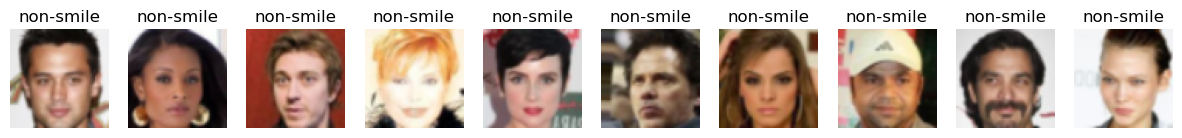

In [5]:
import os
from my_models import *
from my_train import * 
from pretrain_encoder import ResidualBlock, ResNet

import args
import wandb

today = datetime.date.today()
device = torch.device(f"cuda:{args.gpu_num}" if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print(f'오늘 날짜 : {today}')
print(f'cuda device : {device}')

n_gpu = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1
print(f"n_gpu : {n_gpu}")
args.distributed = n_gpu >= 2 

train_loader, test_loader, image, label = prepare_dataloader(args)


E = ResNet(return_features=True).to(device)
E.load_state_dict(torch.load("pretrained/classifier/ResNet_64_parameters_smiling.pt"))
pred, feat_list = E(image.to(device))
G = Generator(feat_list, size=args.img_size, style_dim=args.latent).to(device)
_, styles = G(feat_list)
D = Discriminator(args.img_size, args.latent).to(device)
g_ema = Generator(feat_list, size=args.img_size, style_dim=args.latent).to(device)
P = Predictor(styles).to(device)

g_ema.eval()
accumulate(g_ema, G, 0)

from torch import nn, optim
e_reg_ratio = args.d_reg_every / (args.d_reg_every + 1)
g_reg_ratio = args.g_reg_every / (args.g_reg_every + 1)
d_reg_ratio = args.d_reg_every / (args.d_reg_every + 1)

recon_optim = optim.Adam(G.parameters(),lr=args.lr * g_reg_ratio, betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio))
g_optim = optim.Adam(G.parameters(), lr=args.lr * g_reg_ratio, betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio))
d_optim = optim.Adam(D.parameters(), lr=args.lr * d_reg_ratio, betas=(0 ** d_reg_ratio, 0.99 ** d_reg_ratio))
p_optim = optim.Adam(P.parameters(), lr=args.lr * g_reg_ratio, betas=(0 ** g_reg_ratio, 0.99 ** g_reg_ratio))


In [10]:
if args.ckpt is not None:
    print("load model:", args.ckpt)

    ckpt = torch.load(args.ckpt, map_location=lambda storage, loc: storage)

    try:
        ckpt_name = os.path.basename(args.ckpt)
        args.start_iter = int(os.path.splitext(ckpt_name)[0])

    except ValueError:
        pass

    E.load_state_dict(ckpt["e"])
    G.load_state_dict(ckpt["g"])
    D.load_state_dict(ckpt["d"])
    g_ema.load_state_dict(ckpt["g_ema"])
    recon_optim.load_state_dict(ckpt["recon_optim"])
    g_optim.load_state_dict(ckpt["g_optim"])
    d_optim.load_state_dict(ckpt["d_optim"])


if args.wandb:
    wandb.init(project="StyleGAN2", entity='songyj', name=args.description,
               config=get_config_from_args(args))
torch.autograd.set_detect_anomaly(False)
train(args, train_loader, test_loader, E, G, D, P, recon_optim, p_optim, g_optim, d_optim, g_ema, today, device)


Pred,0.69286
Recon,20.95463
Generator,3.31674
Discriminator,0.09115
Augment,0.00358
Rt,0.92188
R1,0.02191
Path Length Regularization,0.83843
Mean Path Length,0
Real Score,3.66605
Fake Score,-3.11966


Pred,▃▁▄▅▁█▅▃▄▅▇▄▄▄▄▆▃▅▆▄▃▃▄▃▂▅▃▆▆▆▅▄▅▂▆▅▄▆▄▄
Recon,█▇▆▆▆▄▄▆▅▄▄▆▅▃▃▄▃▂▃▅▅▄▄▃▅▂▂▃▄▃▄▃▃▂▃▂▁▂▂▁
Generator,▁▁▁▃▁▃▅▇▆▆▇▁▂▃▃▄▄▅▅▅▇▅▄▄▆▅▆▅█▆▃▃▄▄▅▅▅▆▄▆
Discriminator,▄▄▃▂▃▂▁▁▁▁▁█▄▂▂▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▇▂▁▂▁▁▁▁▁
Augment,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
Rt,▁▁▁▁▁▇▇▇▇▇▇█████▆▆▆▆▆▆███████████▇▇▇▇▇██
R1,▁▁▁▁▁▁▁▁▁▁▁███████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Path Length Regularization,███████████▁▁▁▁▁▁▁▁▁▁▁▄▄▄▄▄▄▄▄▄▄▄▁▁▁▁▁▁▁
Mean Path Length,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Real Score,▂▂▃▄▂▅▇▇▇██▁▂▃▄▄▄▄▄▄▅▄▅▃▃▃▄▄▄▄▄▁▄▅▃▃▄▄▄▄
Fake Score,████▆▇▆▅▅▅▅▂█▇▇▇▆▆▆▆▇▅▇▆▆▅▆▆▆▆▅▁▇▆▆▆▆▆▅▅


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


d: 0.2217; g: 3.5619; p: 0.6930; r1: 0.0134; path: 1.1347; mean path: 0.0375; p: 0.0000; recon_loss: 21.2419;:   0%|          | 0/800000 [00:04<?, ?it/s]

Calculating accuracy...


d: 0.4675; g: 2.7272; p: 0.6844; r1: 0.0146; path: 11.1555; mean path: 0.1101; p: 0.0051; recon_loss: 12.9048;:   0%|          | 100/800000 [04:20<550:59:28,  2.48s/it]

Calculating accuracy...


d: 1.4298; g: 3.1225; p: 0.6914; r1: 0.0238; path: 4.9940; mean path: 0.0770; p: 0.0077; recon_loss: 13.8755;:   0%|          | 200/800000 [08:26<544:55:14,  2.45s/it] 

Calculating accuracy...


d: 0.8341; g: 1.5557; p: 0.6687; r1: 0.0103; path: 4.7717; mean path: 0.0756; p: 0.0118; recon_loss: 13.1085;:   0%|          | 300/800000 [12:28<534:31:15,  2.41s/it]

Calculating accuracy...


d: 0.8613; g: 1.3940; p: 0.5359; r1: 0.0209; path: 5.6000; mean path: 0.0802; p: 0.0123; recon_loss: 12.1661;:   0%|          | 400/800000 [16:23<519:32:34,  2.34s/it]

Calculating accuracy...


d: 0.7652; g: 1.7835; p: 0.5599; r1: 0.0154; path: 5.9870; mean path: 0.0834; p: 0.0108; recon_loss: 12.2517;:   0%|          | 447/800000 [18:16<527:39:06,  2.38s/it]wandb: Network error (ReadTimeout), entering retry loop.
d: 0.7596; g: 1.8902; p: 0.4821; r1: 0.0142; path: 4.9301; mean path: 0.0753; p: 0.0102; recon_loss: 12.8131;:   0%|          | 468/800000 [19:06<526:07:50,  2.37s/it]wandb: Network error resolved after 0:01:23.923032, resuming normal operation.
d: 0.5784; g: 1.4325; p: 0.4378; r1: 0.0220; path: 6.0150; mean path: 0.0822; p: 0.0102; recon_loss: 12.6193;:   0%|          | 500/800000 [20:20<519:45:04,  2.34s/it]

Calculating accuracy...


d: 0.6879; g: 1.5440; p: 0.4420; r1: 0.0246; path: 3.9700; mean path: 0.0676; p: 0.0097; recon_loss: 11.8543;:   0%|          | 600/800000 [24:18<520:02:11,  2.34s/it]

Calculating accuracy...


d: 0.8740; g: 1.4516; p: 0.3641; r1: 0.0187; path: 2.7435; mean path: 0.0570; p: 0.0108; recon_loss: 11.8453;:   0%|          | 700/800000 [28:13<515:16:39,  2.32s/it]

Calculating accuracy...


d: 0.7765; g: 1.3086; p: 0.4461; r1: 0.0248; path: 3.0588; mean path: 0.0594; p: 0.0082; recon_loss: 11.8634;:   0%|          | 800/800000 [32:12<519:24:31,  2.34s/it]

Calculating accuracy...


d: 0.9865; g: 2.9559; p: 0.3930; r1: 0.0261; path: 2.0238; mean path: 0.0492; p: 0.0061; recon_loss: 10.6637;:   0%|          | 900/800000 [36:13<523:22:09,  2.36s/it]

Calculating accuracy...


d: 0.7610; g: 1.6407; p: 0.3802; r1: 0.0293; path: 1.9262; mean path: 0.0484; p: 0.0056; recon_loss: 11.4636;:   0%|          | 1000/800000 [40:14<525:46:18,  2.37s/it]

Calculating accuracy...


d: 0.8778; g: 2.3028; p: 0.3831; r1: 0.0335; path: 1.5279; mean path: 0.0428; p: 0.0036; recon_loss: 11.3289;:   0%|          | 1100/800000 [44:31<537:33:17,  2.42s/it]

Calculating accuracy...


d: 0.9026; g: 1.0041; p: 0.4198; r1: 0.0347; path: 1.3060; mean path: 0.0394; p: 0.0051; recon_loss: 11.7662;:   0%|          | 1200/800000 [48:24<517:49:58,  2.33s/it]

Calculating accuracy...


d: 0.7617; g: 2.2431; p: 0.4189; r1: 0.0235; path: 1.2425; mean path: 0.0391; p: 0.0072; recon_loss: 10.3787;:   0%|          | 1300/800000 [52:17<513:17:38,  2.31s/it]

Calculating accuracy...


d: 0.7491; g: 1.3526; p: 0.4074; r1: 0.0296; path: 1.3163; mean path: 0.0398; p: 0.0077; recon_loss: 10.4860;:   0%|          | 1400/800000 [56:11<511:58:54,  2.31s/it]

Calculating accuracy...


d: 0.9468; g: 0.9719; p: 0.4467; r1: 0.0311; path: 0.8080; mean path: 0.0318; p: 0.0097; recon_loss: 10.6808;:   0%|          | 1500/800000 [1:00:03<507:43:38,  2.29s/it]

Calculating accuracy...


d: 0.9070; g: 1.2780; p: 0.3773; r1: 0.0326; path: 0.8945; mean path: 0.0333; p: 0.0123; recon_loss: 9.6120;:   0%|          | 1600/800000 [1:03:59<511:51:08,  2.31s/it] 

Calculating accuracy...


d: 0.9518; g: 1.9940; p: 0.4426; r1: 0.0259; path: 0.9048; mean path: 0.0336; p: 0.0154; recon_loss: 10.4241;:   0%|          | 1700/800000 [1:08:06<536:03:18,  2.42s/it]

Calculating accuracy...


d: 0.8858; g: 1.6572; p: 0.4823; r1: 0.0285; path: 0.6974; mean path: 0.0299; p: 0.0179; recon_loss: 10.5288;:   0%|          | 1800/800000 [1:12:05<528:21:07,  2.38s/it]

Calculating accuracy...


d: 0.9991; g: 1.0108; p: 0.5136; r1: 0.0321; path: 0.7686; mean path: 0.0313; p: 0.0189; recon_loss: 10.1289;:   0%|          | 1900/800000 [1:16:11<534:28:09,  2.41s/it]

Calculating accuracy...


d: 1.0765; g: 0.6490; p: 0.4129; r1: 0.0179; path: 0.6931; mean path: 0.0298; p: 0.0215; recon_loss: 10.7859;:   0%|          | 2000/800000 [1:20:09<523:28:01,  2.36s/it]

Calculating accuracy...


d: 1.1000; g: 1.0601; p: 0.4133; r1: 0.0554; path: 0.5443; mean path: 0.0263; p: 0.0215; recon_loss: 10.4284;:   0%|          | 2100/800000 [1:24:10<520:28:49,  2.35s/it]

Calculating accuracy...


d: 0.7196; g: 1.4740; p: 0.4179; r1: 0.0245; path: 0.6164; mean path: 0.0278; p: 0.0241; recon_loss: 10.6438;:   0%|          | 2200/800000 [1:27:59<507:32:17,  2.29s/it]

Calculating accuracy...


d: 0.8606; g: 1.6149; p: 0.3748; r1: 0.0253; path: 0.5241; mean path: 0.0263; p: 0.0251; recon_loss: 10.5909;:   0%|          | 2300/800000 [1:31:50<504:32:08,  2.28s/it]

Calculating accuracy...


d: 0.9766; g: 1.3864; p: 0.3907; r1: 0.0321; path: 0.5545; mean path: 0.0267; p: 0.0266; recon_loss: 10.0495;:   0%|          | 2400/800000 [1:35:40<502:32:19,  2.27s/it]

Calculating accuracy...


d: 1.0535; g: 1.8112; p: 0.5691; r1: 0.0387; path: 0.5972; mean path: 0.0279; p: 0.0266; recon_loss: 10.6343;:   0%|          | 2500/800000 [1:39:33<507:16:42,  2.29s/it]

Calculating accuracy...


d: 0.9487; g: 1.0307; p: 0.3757; r1: 0.0372; path: 0.5014; mean path: 0.0256; p: 0.0292; recon_loss: 9.8689;:   0%|          | 2600/800000 [1:43:28<508:02:56,  2.29s/it] 

Calculating accuracy...


d: 0.8505; g: 0.8614; p: 0.3880; r1: 0.0194; path: 0.4828; mean path: 0.0250; p: 0.0333; recon_loss: 9.6221;:   0%|          | 2700/800000 [1:47:27<515:37:59,  2.33s/it] 

Calculating accuracy...


d: 0.8354; g: 0.8931; p: 0.4142; r1: 0.0389; path: 0.5048; mean path: 0.0258; p: 0.0338; recon_loss: 9.7619;:   0%|          | 2800/800000 [1:51:24<513:40:22,  2.32s/it] 

Calculating accuracy...


d: 1.3202; g: 1.0641; p: 0.3695; r1: 0.0391; path: 0.4044; mean path: 0.0230; p: 0.0358; recon_loss: 9.9848;:   0%|          | 2900/800000 [1:55:17<510:03:40,  2.30s/it] 

Calculating accuracy...


d: 1.0667; g: 1.4784; p: 0.4078; r1: 0.0197; path: 0.4174; mean path: 0.0236; p: 0.0343; recon_loss: 9.2413;:   0%|          | 3000/800000 [1:59:07<504:50:15,  2.28s/it] 

Calculating accuracy...


d: 0.8766; g: 1.9028; p: 0.3154; r1: 0.0309; path: 0.4209; mean path: 0.0235; p: 0.0343; recon_loss: 9.4275;:   0%|          | 3100/800000 [2:03:16<517:46:00,  2.34s/it] 

Calculating accuracy...


d: 1.0828; g: 0.6742; p: 0.3671; r1: 0.0195; path: 0.3965; mean path: 0.0226; p: 0.0358; recon_loss: 9.4629;:   0%|          | 3200/800000 [2:07:04<504:36:03,  2.28s/it] 

Calculating accuracy...


d: 1.0045; g: 0.6114; p: 0.3446; r1: 0.0387; path: 0.3719; mean path: 0.0221; p: 0.0369; recon_loss: 10.7524;:   0%|          | 3300/800000 [2:10:55<504:30:51,  2.28s/it]

Calculating accuracy...


d: 0.8784; g: 1.5323; p: 0.3712; r1: 0.0289; path: 0.4089; mean path: 0.0232; p: 0.0394; recon_loss: 10.9455;:   0%|          | 3400/800000 [2:14:45<501:21:46,  2.27s/it]

Calculating accuracy...


d: 1.0590; g: 0.5220; p: 0.4112; r1: 0.0396; path: 0.4075; mean path: 0.0234; p: 0.0394; recon_loss: 9.5272;:   0%|          | 3500/800000 [2:18:35<502:05:48,  2.27s/it] 

Calculating accuracy...


d: 0.9993; g: 1.5891; p: 0.3880; r1: 0.0256; path: 0.3367; mean path: 0.0214; p: 0.0399; recon_loss: 10.1190;:   0%|          | 3600/800000 [2:22:36<516:02:17,  2.33s/it]

Calculating accuracy...


d: 1.0682; g: 0.6104; p: 0.3720; r1: 0.0404; path: 0.4029; mean path: 0.0230; p: 0.0420; recon_loss: 9.2884;:   0%|          | 3700/800000 [2:26:26<507:15:48,  2.29s/it] 

Calculating accuracy...


d: 1.0645; g: 0.8304; p: 0.3754; r1: 0.0492; path: 0.4139; mean path: 0.0234; p: 0.0415; recon_loss: 9.6945;:   0%|          | 3800/800000 [2:30:18<506:00:59,  2.29s/it] 

Calculating accuracy...


d: 1.1259; g: 0.6505; p: 0.3902; r1: 0.0259; path: 0.3359; mean path: 0.0212; p: 0.0415; recon_loss: 8.9604;:   0%|          | 3900/800000 [2:34:10<505:06:56,  2.28s/it] 

Calculating accuracy...


d: 0.9574; g: 0.8986; p: 0.3364; r1: 0.0265; path: 0.3228; mean path: 0.0206; p: 0.0430; recon_loss: 9.3065;:   0%|          | 4000/800000 [2:37:58<499:29:38,  2.26s/it] 

Calculating accuracy...


d: 0.9743; g: 1.5392; p: 0.4460; r1: 0.0352; path: 0.3825; mean path: 0.0225; p: 0.0420; recon_loss: 9.3904;:   1%|          | 4100/800000 [2:41:59<509:27:11,  2.30s/it] 

Calculating accuracy...


d: 0.9216; g: 1.5367; p: 0.4083; r1: 0.0277; path: 0.3727; mean path: 0.0222; p: 0.0456; recon_loss: 9.4657;:   1%|          | 4200/800000 [2:45:48<502:06:38,  2.27s/it] 

Calculating accuracy...


d: 1.0327; g: 1.6258; p: 0.3802; r1: 0.0256; path: 0.3323; mean path: 0.0211; p: 0.0456; recon_loss: 9.2222;:   1%|          | 4300/800000 [2:49:40<501:45:08,  2.27s/it] 

Calculating accuracy...


d: 1.3390; g: 1.2742; p: 0.3813; r1: 0.0196; path: 0.3217; mean path: 0.0208; p: 0.0440; recon_loss: 9.5270;:   1%|          | 4400/800000 [2:53:35<508:18:25,  2.30s/it] 

Calculating accuracy...


d: 0.8977; g: 1.8267; p: 0.3696; r1: 0.0157; path: 0.3025; mean path: 0.0202; p: 0.0461; recon_loss: 10.0511;:   1%|          | 4500/800000 [2:57:31<509:42:14,  2.31s/it]

Calculating accuracy...


d: 1.1563; g: 1.5147; p: 0.4207; r1: 0.0457; path: 0.3501; mean path: 0.0217; p: 0.0456; recon_loss: 9.3668;:   1%|          | 4600/800000 [3:01:18<499:40:44,  2.26s/it] 

Calculating accuracy...


d: 0.9245; g: 1.2254; p: 0.3305; r1: 0.0293; path: 0.3137; mean path: 0.0205; p: 0.0456; recon_loss: 10.1285;:   1%|          | 4700/800000 [3:05:05<495:08:49,  2.24s/it]

Calculating accuracy...


d: 1.0124; g: 0.8173; p: 0.4112; r1: 0.0265; path: 0.2826; mean path: 0.0195; p: 0.0471; recon_loss: 9.0091;:   1%|          | 4800/800000 [3:08:53<495:15:10,  2.24s/it] 

Calculating accuracy...


d: 0.9861; g: 0.6775; p: 0.3607; r1: 0.0242; path: 0.3193; mean path: 0.0206; p: 0.0492; recon_loss: 9.5841;:   1%|          | 4900/800000 [3:12:40<493:31:42,  2.23s/it] 

Calculating accuracy...


d: 0.9847; g: 1.1769; p: 0.4056; r1: 0.0361; path: 0.3102; mean path: 0.0202; p: 0.0486; recon_loss: 9.6964;:   1%|          | 5000/800000 [3:16:29<496:19:16,  2.25s/it] 

Calculating accuracy...


d: 1.0350; g: 1.2256; p: 0.3137; r1: 0.0353; path: 0.3223; mean path: 0.0207; p: 0.0507; recon_loss: 8.4022;:   1%|          | 5100/800000 [3:20:42<517:19:52,  2.34s/it] 

Calculating accuracy...


d: 1.3440; g: 1.3399; p: 0.3765; r1: 0.0125; path: 0.2669; mean path: 0.0188; p: 0.0512; recon_loss: 8.4921;:   1%|          | 5200/800000 [3:24:33<509:42:00,  2.31s/it] 

Calculating accuracy...


d: 1.0984; g: 1.4966; p: 0.3491; r1: 0.0315; path: 0.2954; mean path: 0.0198; p: 0.0502; recon_loss: 9.5037;:   1%|          | 5300/800000 [3:28:28<509:51:56,  2.31s/it] 

Calculating accuracy...


d: 0.8423; g: 1.0198; p: 0.3762; r1: 0.0347; path: 0.2884; mean path: 0.0195; p: 0.0507; recon_loss: 9.6793;:   1%|          | 5400/800000 [3:32:15<499:32:19,  2.26s/it] 

Calculating accuracy...


d: 0.9957; g: 0.7586; p: 0.3609; r1: 0.0273; path: 0.2983; mean path: 0.0199; p: 0.0502; recon_loss: 9.0481;:   1%|          | 5412/800000 [3:32:48<515:10:28,  2.33s/it] wandb: Network error (ReadTimeout), entering retry loop.
d: 0.9259; g: 1.2721; p: 0.4535; r1: 0.0347; path: 0.3090; mean path: 0.0203; p: 0.0512; recon_loss: 9.6442;:   1%|          | 5426/800000 [3:33:19<510:56:31,  2.31s/it] wandb: Network error resolved after 0:01:04.327184, resuming normal operation.
d: 1.0141; g: 1.9008; p: 0.4447; r1: 0.0227; path: 0.2685; mean path: 0.0190; p: 0.0538; recon_loss: 9.2519;:   1%|          | 5500/800000 [3:36:02<494:26:08,  2.24s/it] 

Calculating accuracy...


d: 1.2221; g: 0.7475; p: 0.3450; r1: 0.0141; path: 0.2651; mean path: 0.0186; p: 0.0522; recon_loss: 8.8572;:   1%|          | 5600/800000 [3:40:18<546:25:42,  2.48s/it] 

Calculating accuracy...


d: 1.0127; g: 1.2353; p: 0.4040; r1: 0.0275; path: 0.2421; mean path: 0.0179; p: 0.0502; recon_loss: 9.2884;:   1%|          | 5700/800000 [3:44:49<556:35:24,  2.52s/it] 

Calculating accuracy...


d: 0.8829; g: 1.0164; p: 0.4667; r1: 0.0341; path: 0.2699; mean path: 0.0190; p: 0.0517; recon_loss: 8.7224;:   1%|          | 5800/800000 [3:48:45<530:02:41,  2.40s/it] 

Calculating accuracy...


d: 0.8810; g: 0.8694; p: 0.3444; r1: 0.0263; path: 0.3115; mean path: 0.0203; p: 0.0538; recon_loss: 9.4216;:   1%|          | 5900/800000 [3:52:45<523:21:33,  2.37s/it] 

Calculating accuracy...


d: 0.9721; g: 1.0586; p: 0.4418; r1: 0.0276; path: 0.2943; mean path: 0.0197; p: 0.0532; recon_loss: 8.9515;:   1%|          | 6000/800000 [3:56:48<523:53:19,  2.38s/it] 

Calculating accuracy...


d: 0.9498; g: 1.4587; p: 0.3212; r1: 0.0226; path: 0.2468; mean path: 0.0182; p: 0.0543; recon_loss: 8.8834;:   1%|          | 6100/800000 [4:01:18<554:17:13,  2.51s/it] 

Calculating accuracy...


d: 1.0030; g: 0.9665; p: 0.3713; r1: 0.0348; path: 0.3098; mean path: 0.0200; p: 0.0568; recon_loss: 8.5853;:   1%|          | 6200/800000 [4:05:19<537:06:07,  2.44s/it] 

Calculating accuracy...


d: 1.0145; g: 0.6786; p: 0.3760; r1: 0.0349; path: 0.2906; mean path: 0.0194; p: 0.0568; recon_loss: 8.5231;:   1%|          | 6300/800000 [4:09:10<512:46:02,  2.33s/it] 

Calculating accuracy...


d: 0.9732; g: 0.8549; p: 0.3706; r1: 0.0404; path: 0.2721; mean path: 0.0191; p: 0.0553; recon_loss: 8.0949;:   1%|          | 6400/800000 [4:13:02<504:32:53,  2.29s/it] 

Calculating accuracy...


d: 1.0352; g: 0.8765; p: 0.3759; r1: 0.0106; path: 0.2309; mean path: 0.0176; p: 0.0553; recon_loss: 8.6482;:   1%|          | 6500/800000 [4:16:56<505:32:35,  2.29s/it] 

Calculating accuracy...


d: 1.0437; g: 0.7936; p: 0.3135; r1: 0.0508; path: 0.2560; mean path: 0.0183; p: 0.0538; recon_loss: 8.0638;:   1%|          | 6600/800000 [4:20:50<507:15:06,  2.30s/it] 

Calculating accuracy...


d: 1.0689; g: 0.5815; p: 0.4375; r1: 0.0224; path: 0.2734; mean path: 0.0190; p: 0.0558; recon_loss: 9.0207;:   1%|          | 6700/800000 [4:24:50<514:03:16,  2.33s/it]

Calculating accuracy...


d: 1.1898; g: 1.2163; p: 0.3659; r1: 0.0271; path: 0.2444; mean path: 0.0180; p: 0.0543; recon_loss: 8.4831;:   1%|          | 6800/800000 [4:28:55<524:53:06,  2.38s/it] 

Calculating accuracy...


d: 1.0118; g: 0.8685; p: 0.3563; r1: 0.0308; path: 0.2432; mean path: 0.0178; p: 0.0532; recon_loss: 8.5371;:   1%|          | 6900/800000 [4:32:53<517:44:43,  2.35s/it] 

Calculating accuracy...


d: 0.9114; g: 0.7167; p: 0.3417; r1: 0.0242; path: 0.2681; mean path: 0.0187; p: 0.0527; recon_loss: 8.7807;:   1%|          | 7000/800000 [4:36:49<512:52:59,  2.33s/it]

Calculating accuracy...


d: 1.0466; g: 1.3987; p: 0.3661; r1: 0.0463; path: 0.2823; mean path: 0.0191; p: 0.0497; recon_loss: 9.3374;:   1%|          | 7100/800000 [4:40:54<522:45:05,  2.37s/it]

Calculating accuracy...


d: 1.1254; g: 0.4903; p: 0.3658; r1: 0.0173; path: 0.2367; mean path: 0.0177; p: 0.0522; recon_loss: 8.7397;:   1%|          | 7200/800000 [4:44:45<508:16:30,  2.31s/it]

Calculating accuracy...


d: 0.9395; g: 0.8899; p: 0.3465; r1: 0.0171; path: 0.2518; mean path: 0.0181; p: 0.0502; recon_loss: 8.5853;:   1%|          | 7300/800000 [4:48:39<509:21:42,  2.31s/it]

Calculating accuracy...


d: 0.9201; g: 0.8407; p: 0.5002; r1: 0.0212; path: 0.2890; mean path: 0.0193; p: 0.0497; recon_loss: 8.5970;:   1%|          | 7400/800000 [4:52:40<518:46:47,  2.36s/it] 

Calculating accuracy...


d: 0.9661; g: 0.7595; p: 0.3864; r1: 0.0239; path: 0.2666; mean path: 0.0186; p: 0.0486; recon_loss: 9.2193;:   1%|          | 7500/800000 [4:56:29<504:29:42,  2.29s/it] 

Calculating accuracy...


d: 1.0151; g: 0.9409; p: 0.3769; r1: 0.0297; path: 0.2604; mean path: 0.0184; p: 0.0492; recon_loss: 7.7193;:   1%|          | 7600/800000 [5:00:48<535:13:04,  2.43s/it]

Calculating accuracy...


d: 0.9596; g: 0.9848; p: 0.3204; r1: 0.0287; path: 0.2730; mean path: 0.0189; p: 0.0502; recon_loss: 8.9885;:   1%|          | 7700/800000 [5:05:40<606:04:07,  2.75s/it]

Calculating accuracy...


d: 0.9646; g: 0.6880; p: 0.3465; r1: 0.0126; path: 0.2352; mean path: 0.0176; p: 0.0527; recon_loss: 8.1608;:   1%|          | 7800/800000 [5:13:07<905:34:50,  4.12s/it]

Calculating accuracy...


d: 1.0127; g: 1.2792; p: 0.4384; r1: 0.0275; path: 0.2830; mean path: 0.0189; p: 0.0517; recon_loss: 7.8653;:   1%|          | 7900/800000 [5:21:23<950:28:09,  4.32s/it] 

Calculating accuracy...


d: 1.0182; g: 0.4854; p: 0.3752; r1: 0.0245; path: 0.2298; mean path: 0.0174; p: 0.0522; recon_loss: 7.8306;:   1%|          | 8000/800000 [5:25:31<693:27:35,  3.15s/it]

Calculating accuracy...


d: 0.9656; g: 1.0919; p: 0.3753; r1: 0.0253; path: 0.2258; mean path: 0.0172; p: 0.0512; recon_loss: 8.3209;:   1%|          | 8087/800000 [5:34:39<1129:05:58,  5.13s/it]

# Debug